In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm

### Monte Carlo

In [2]:
So = 13.71
T = 1
vol = 1.21
rf = 0.06
k = 18.07

In [3]:
mc = pd.DataFrame({'counter': range(1,1000001,1),'norm' : np.random.normal(size=(1000000))})
mc['ST'] = So *math.e**((rf - (1/2)*vol**2)*T + vol*np.sqrt(T) * mc.norm)
mc['VT'] =  np.where(mc.ST-k > 0, mc.ST-k, 0)
mc

,counter,norm,ST,VT
0,1,1.972275,76.136556,58.066556
1,2,0.359452,10.815854,0.000000
2,3,-1.824245,0.770080,0.000000
3,4,-1.776246,0.816130,0.000000
4,5,-0.900176,2.355758,0.000000
...,...,...,...,...
999995,999996,-0.034384,6.715851,0.000000
999996,999997,0.985196,23.061453,4.991453
999997,999998,1.001445,23.519372,5.449372
999998,999999,-1.110896,1.825568,0.000000


In [4]:
print(f'Average Norm: {mc.norm.mean():.2} \n Average  ST: {mc.ST.mean():.4} \n  Average VT: {mc.VT.mean():.4}')

Average Norm: 5.8e-05 
 Average  ST: 14.57 
  Average VT: 5.782


In [5]:
val = mc.VT.mean() / math.e**(rf * T)
print(f' Value: {val:.4}')

 Value: 5.445


## Multiple Uncertainty
#### Strike price changes with uncertainty

In [6]:
corr = .3
mc2 = pd.DataFrame({'counter': range(1,100001,1),'Z1' : np.random.normal(size=(100000)),'Z2' : np.random.normal(size=(100000))})
mc2['ST'] = So *math.e**((rf - (1/2)*vol**2)*T + vol*np.sqrt(T) * mc2.Z1)
mc2['eps'] = corr * mc2.Z1 + mc2.Z2*np.sqrt(1-corr**2)
mc2['KT'] = k*math.e**((rf - .5 *vol**2) * T + vol * np.sqrt(T) * mc2.eps)
mc2['VT'] = np.where(mc2.ST-mc2.KT>0,mc2.ST-mc2.KT,0)
mc2

,counter,Z1,Z2,ST,eps,KT,VT
0,1,-0.909419,-0.378339,2.329558,-0.633738,4.286111,0.000000
1,2,-0.451593,1.033503,4.053773,0.850421,25.821637,0.000000
2,3,-0.212092,0.897088,5.416466,0.792140,24.063407,0.000000
3,4,0.749166,-0.971704,17.332205,-0.702197,3.945378,13.386827
4,5,0.282375,0.829851,9.852740,0.876340,26.644275,0.000000
...,...,...,...,...,...,...,...
99995,99996,0.141916,-0.998266,8.312777,-0.909711,3.069311,5.243466
99996,99997,0.276026,-0.085846,9.777332,0.000916,9.237869,0.539462
99997,99998,-0.270362,-0.907923,5.047721,-0.947212,2.933148,2.114574
99998,99999,1.508401,2.600884,43.433940,2.933606,321.136354,0.000000


In [7]:
print(f'Average Norm: {mc2.Z1.mean():.2} \n Average  ST: {mc2.ST.mean():.4} \n  Average VT: {mc2.KT.mean():.4} \n  Average VT: {mc2.VT.mean():.4}')

Average Norm: -0.0042 
 Average  ST: 14.53 
  Average VT: 19.32 
  Average VT: 6.681


In [8]:
val2 = mc2.VT.mean() * math.e**(-rf * T)
print(f' Value: {val2:.4}')

 Value: 6.292


##  BSM

In [9]:
def blackscholes(option,so,k,rf,t,vol,div=0):
    d1 = (np.log(so/k)+(rf-div+vol**2/2)*t)/(vol*np.sqrt(t))
    d2 = d1-vol*np.sqrt(t)
    if option == 'call':
        call = so*math.e**(-div*t) * norm.cdf(d1) - k*math.e**(-rf*t) * norm.cdf(d2)
        return call
    elif option == 'put':
        put = k*math.e**(-rf*t)*norm.cdf(-d2) - so*math.e**(-div*t)*norm.cdf(-d1)
        return put
    

In [10]:
k = 18.07
So = 13.71
rf = 0.06
vol = 1.21
T = 1
blackscholes('call',So, k, rf,T,vol)

5.431741035648174

## Binomial Tree

In [11]:
# def binomial_tree(so, vol, rf, k, t):

k = 18.07
So = 13.71
rf = 0.06
vol = 1.21
T = 1/12
t = 12

# k = 35
# So = 30
# rf = 0.05
# vol = 0.4
# T = 1/12
# t = 12

up = math.e**(vol * np.sqrt(T))
do = 1/up
q = (math.e**(rf * T)-do)/(up-do)
print(up, do, q)

1.4180701711113846 0.7051837210680976 0.420584231574464


In [24]:
def binomial_tree(so,vol,rf,k,T, steps):
    up = math.e**(vol * np.sqrt(T/steps))
    down = 1/up
    q = (math.e**(rf * T/steps)-down)/(up-down)
    
    df = pd.DataFrame(data={'0':[so]})
    for i in range(steps):
        df[f'{i+1}'] = df[f'{0+i}'] * up
    for i in range(1,steps+1):
        df.loc[i,:] = (df.loc[-1+i,:] * down).shift(1)
#     print(df)
    df2 = df
    df2[f'{steps}'] = np.where(df[f'{steps}'] - k>0, df[f'{steps}'] - k,0)
    
    for i in range(1,steps+1):
        df2[f'{steps-i}'] = (q * df2[f'{steps+1-i}'] + (1-q)*df2[f'{steps+1-i}'].shift(-1))/math.e**(rf * (1/steps))
#     print(df2)
    return df2.iloc[0,0]

In [25]:
binomial_tree(So,vol,rf,k,1,12)

5.5270726361904785

In [26]:
vals = pd.DataFrame()
for i in range(1,101):
#     print(i)
    vals = vals.append(pd.Series([i, binomial_tree(So,vol,rf,k,1,i)]), ignore_index=True)
vals

,0,1
0,1.0,6.568714
1,2.0,5.371073
2,3.0,5.724090
3,4.0,5.519335
4,5.0,5.542850
...,...,...
95,96.0,5.426635
96,97.0,5.443181
97,98.0,5.427809
98,99.0,5.442591


In [27]:
vals = vals.rename(columns={0:'Steps',1:'Binomial Tree Value'})

5.431741035648174


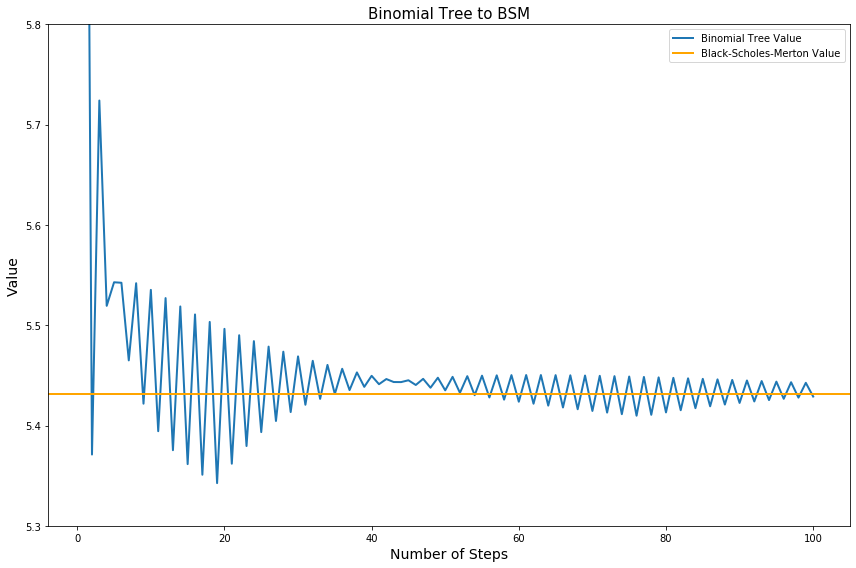

In [28]:
k = 18.07
So = 13.71
rf = 0.06
vol = 1.21
T = 1
bsm = blackscholes('call',So, k, rf,T,vol)
print(bsm)
plt.figure(figsize=(12,8))
sns.lineplot(x=vals.Steps, y = vals['Binomial Tree Value'], label='Binomial Tree Value', linewidth = 2)
plt.title('Binomial Tree to BSM', fontsize=15)
plt.xlabel('Number of Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
axes = plt.gca()
axes.set_ylim([5.3,5.8])
plt.axhline(y=blackscholes('call',So, k, rf,T,vol), color='orange', linestyle='-', linewidth=2, label = 'Black-Scholes-Merton Value')
plt.legend()
plt.tight_layout()